# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from catboost import CatBoostClassifier, Pool

from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

In [106]:
# Load data
train_label = pd.read_csv('data/train_labels.csv')
train_features = pd.read_csv('data/train_values.csv')
test_features = pd.read_csv('data/test_values.csv')
submission = pd.read_csv('data/SubmissionFormat.csv')

In [107]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Preprocessing
- Dropped `num_private`, `recorded_by`, & `date_recorded` features
- Change `region_code` & `district_code` to 'object' type
- Change `construction_year` to 'object' type
- Convert `date_recorded` into year, month, & day features

#### Changes
- Adjust class weights via CatBoost
- OneHotEncode categorical variables via CatBoost

In [108]:
# Convert 'region_code', 'district_code', 'construction_year' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Drop columns 'num_private', 'recorded_by', 'date_recorded' (and 'id' from train_df)
train_df = train_df.drop(columns=['num_private', 'recorded_by', 'date_recorded', 'id'])
test_features = test_features.drop(columns=['num_private', 'recorded_by', 'date_recorded'])

In [109]:
# Split `train_df` into train and test sets before additional encoding to prevent data leakage
X = train_df.drop(columns='status_group', axis=1)
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=604)

In [110]:
# Fill Categorical Columns with missing values in X_train, X_test, and test_features with 'unknown'
categorical_columns = X.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('unknown')
X_test[categorical_columns] = X_test[categorical_columns].fillna('unknown')
test_features[categorical_columns] = test_features[categorical_columns].fillna('unknown')

In [111]:
# Ensure all specified categorical columns are converted to 'object' type in the test set
for col in categorical_columns:
    if col in test_features.columns:
        test_features[col] = test_features[col].astype('object')

In [112]:
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name' if less than 200
# 200 appears to be the best threshold based on RF (vs. 100 or 300)

# Define the columns to be transformed
columns_to_transform = ['funder', 'installer', 'wpt_name',
                        'subvillage', 'scheme_name', 'ward'] # Try reducing features

# Function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, columns, threshold=200):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'Other')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

# CatBoost

In [123]:
# Identify categorical feature indices
categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object']).columns]

# Create a Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Define parameter grid
cb_param_grid = {
    'iterations': [1000],
    'depth': [10], #[6, 8, 10],
    'learning_rate': [0.1], #[0.01, 0.1],
    'l2_leaf_reg': [1], #[1, 5, 9],
    'one_hot_max_size': [150] #[100, 150]
}

# Best parameters: {'depth': 10, 'one_hot_max_size': 150, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500}

# Initialize CatBoost model
cb_model = CatBoostClassifier(random_state=42)

In [124]:
%%time
# Perform grid search
cb_gscv = cb_model.grid_search(cb_param_grid, train_pool, cv=3, verbose=False)

0:	learn: 1.0244057	test: 1.0253419	best: 1.0253419 (0)	total: 39.1ms	remaining: 39s
1:	learn: 0.9658258	test: 0.9673484	best: 0.9673484 (1)	total: 78.3ms	remaining: 39.1s
2:	learn: 0.9173494	test: 0.9202319	best: 0.9202319 (2)	total: 171ms	remaining: 57s
3:	learn: 0.8777704	test: 0.8812095	best: 0.8812095 (3)	total: 215ms	remaining: 53.4s
4:	learn: 0.8453632	test: 0.8494791	best: 0.8494791 (4)	total: 287ms	remaining: 57.1s
5:	learn: 0.8158487	test: 0.8207753	best: 0.8207753 (5)	total: 352ms	remaining: 58.3s
6:	learn: 0.7897034	test: 0.7954808	best: 0.7954808 (6)	total: 398ms	remaining: 56.5s
7:	learn: 0.7697064	test: 0.7762605	best: 0.7762605 (7)	total: 469ms	remaining: 58.2s
8:	learn: 0.7524910	test: 0.7595808	best: 0.7595808 (8)	total: 511ms	remaining: 56.3s
9:	learn: 0.7360292	test: 0.7435346	best: 0.7435346 (9)	total: 550ms	remaining: 54.4s
10:	learn: 0.7218269	test: 0.7298178	best: 0.7298178 (10)	total: 589ms	remaining: 52.9s
11:	learn: 0.7074634	test: 0.7161566	best: 0.7161566 (

In [125]:
# Access the best parameters
cb_best_params = cb_gscv['params']
print(f"Best parameters: {cb_best_params}")

Best parameters: {'depth': 10, 'one_hot_max_size': 150, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000}


In [126]:
# Evaluate the best model
cb_preds = cb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, cb_preds)}")
print(classification_report(y_test, cb_preds))

Accuracy: 0.8013468013468014
                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9678
functional needs repair       0.57      0.29      0.39      1295
         non functional       0.84      0.76      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.74      0.65      0.68     17820
           weighted avg       0.79      0.80      0.79     17820



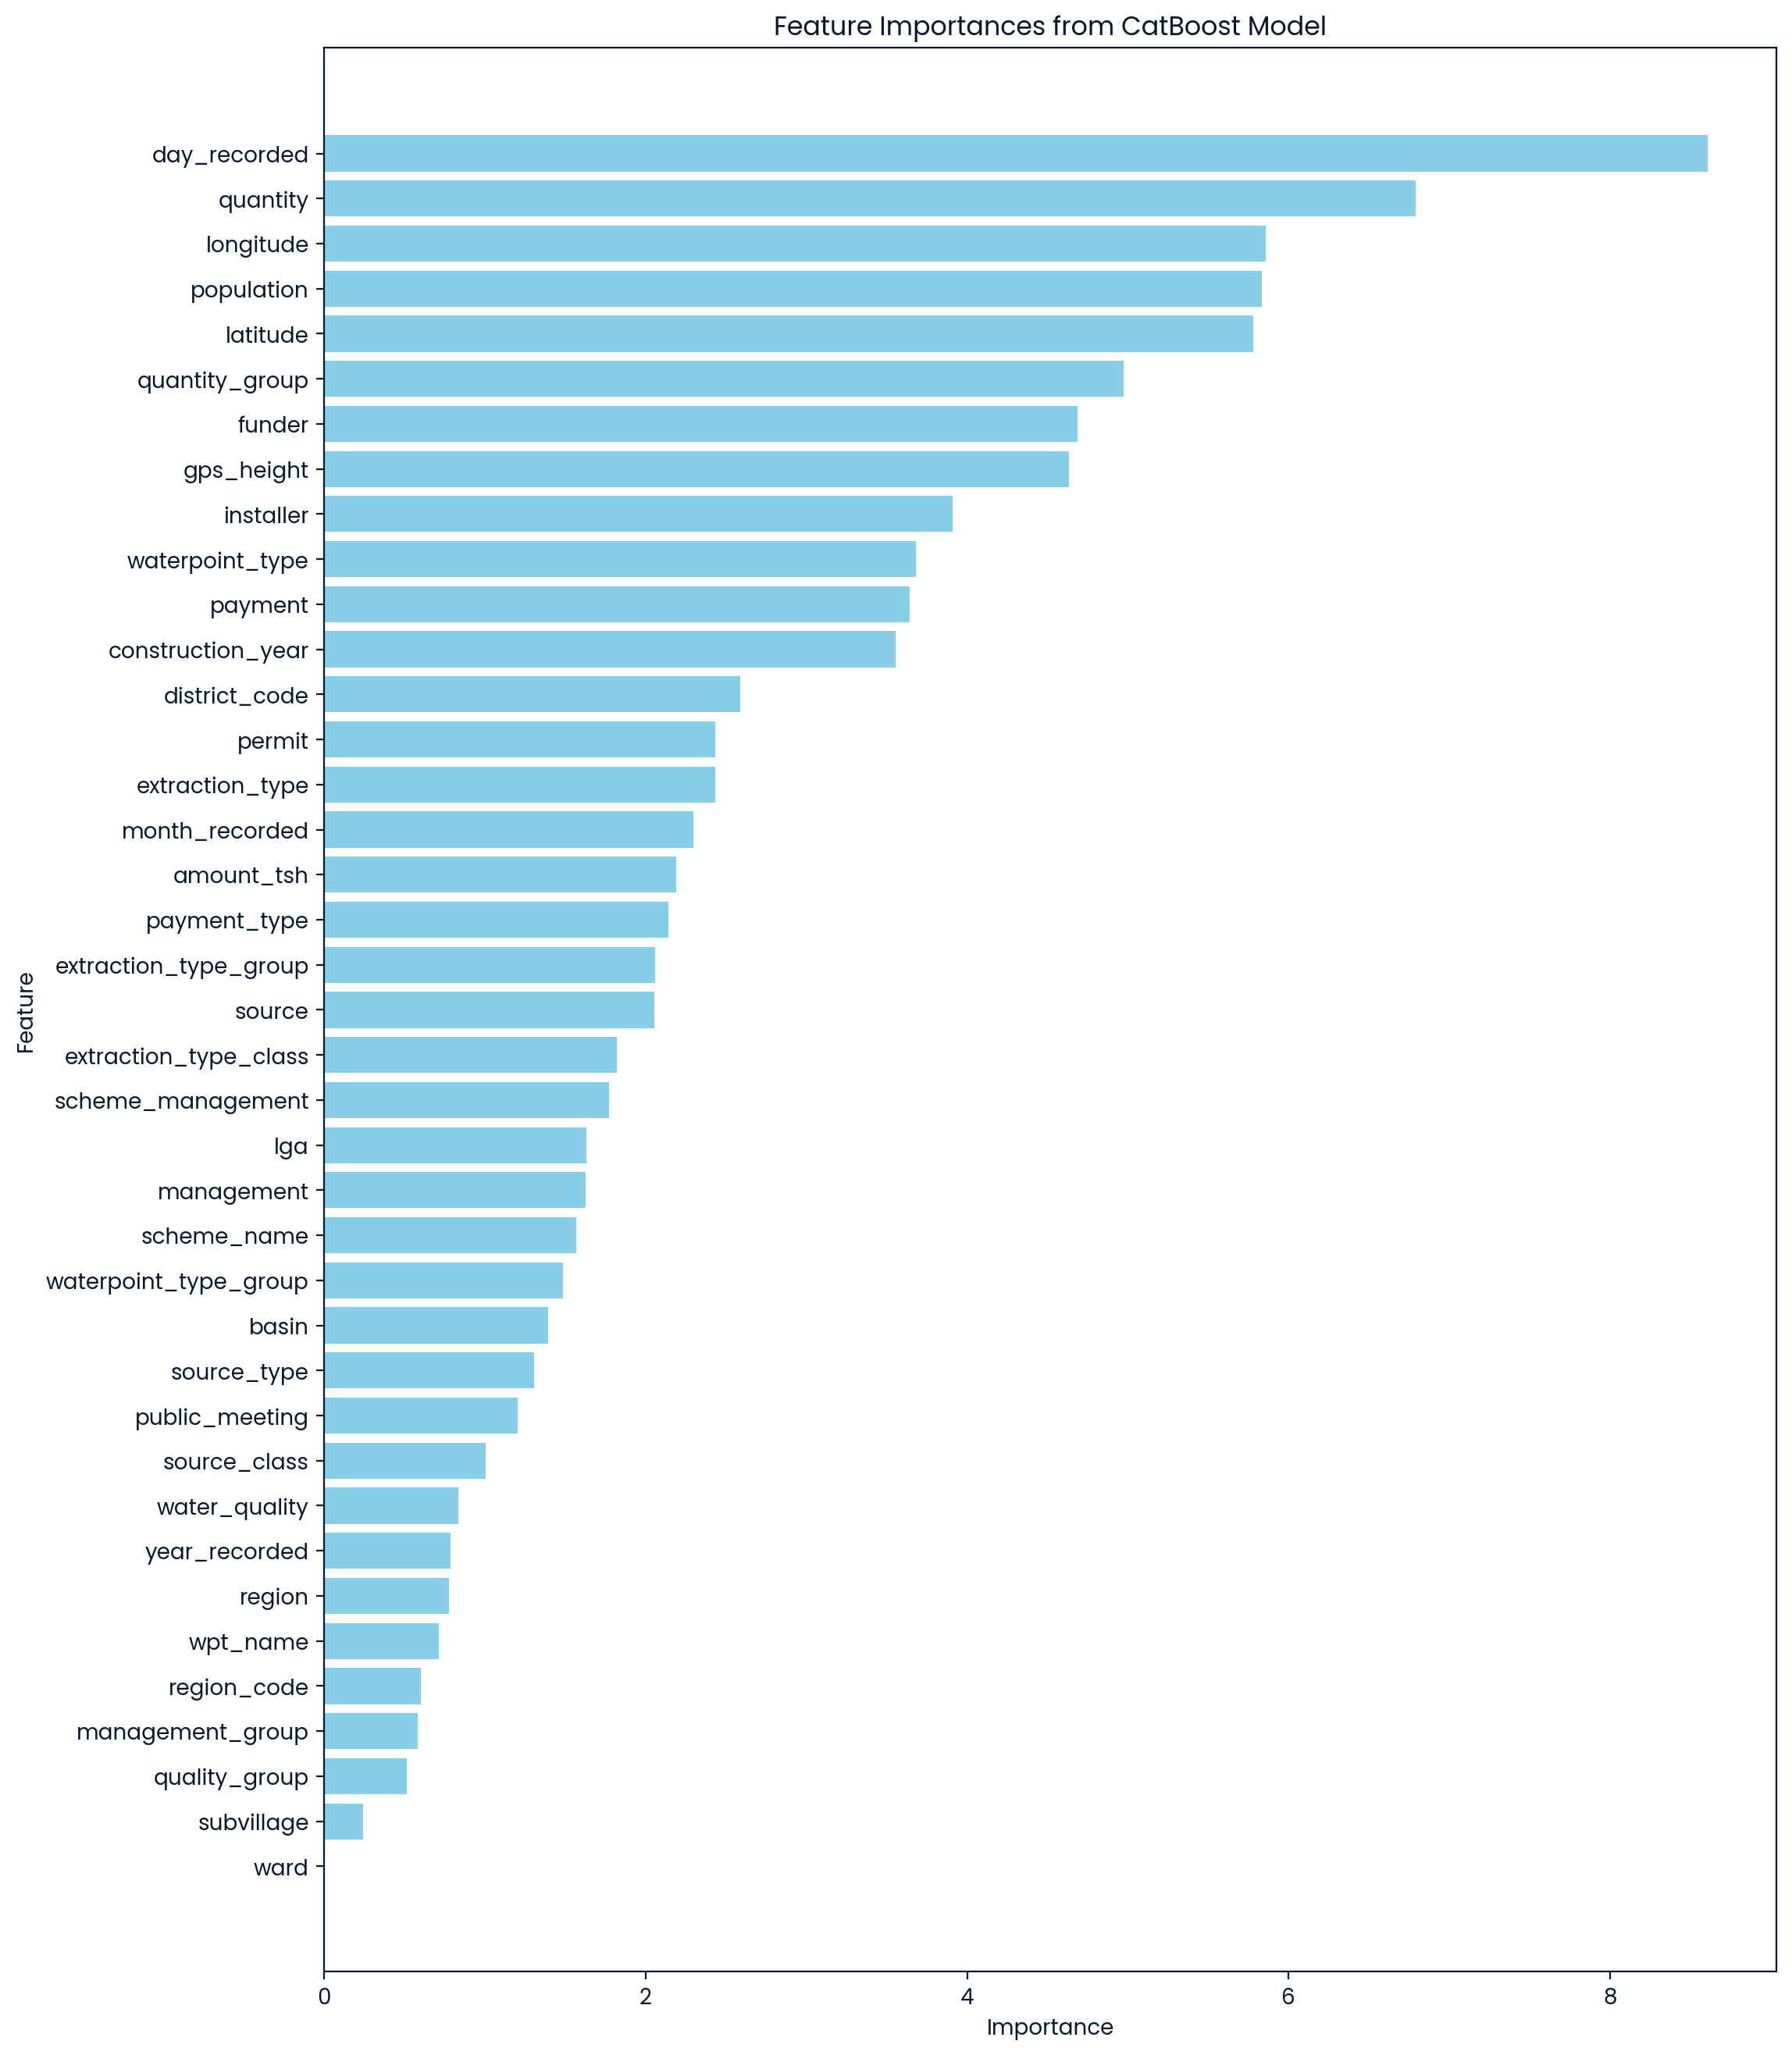

In [127]:
# Get feature importances from the CatBoost model
cb_feature_importances = cb_model.get_feature_importance()

# Create a DataFrame for better visualization
cb_features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_feature_importances
})

# Sort the DataFrame by importance
cb_features_df = cb_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 16))
plt.barh(cb_features_df['Feature'], cb_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [129]:
# Need to drop otherise causes error
#test_features = test_features.drop(columns='id')

# Predict using CatBoost model
cb_test_preds = cb_model.predict(test_features)

# Ensure catboost_test_preds is a 1-dimensional array
cb_test_preds = cb_test_preds.flatten()

# Replace values in 'status_group' with catboost_test_preds
submission['status_group'] = cb_test_preds

submission.to_csv('submission_cb5b.csv', index=False)